In [36]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

import os
from datetime import datetime
import sys
try:
    from iterstrat.ml_stratifiers import MultilabelStratifiedKFold  # trainML
except:
    sys.path.append("../input/iterative-stratification")  # kaggle
    from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

ModuleNotFoundError: No module named 'iterstrat'

In [37]:
BASE_PATH = os.environ.get('TRAINML_DATA_PATH') if os.environ.get('TRAINML_DATA_PATH') else '../input/lish-moa'
BASE_PATH

'/opt/data'

In [38]:
train_features = pd.read_csv(f'{BASE_PATH}/train_features.csv')
train_targets = pd.read_csv(f'{BASE_PATH}/train_targets_scored.csv')
test_features = pd.read_csv(f'{BASE_PATH}/test_features.csv')

sample_submission = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')

In [39]:
def preprocess(df):
    df = df.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    del df['sig_id']
    return df

train_data = preprocess(train_features)
test_data = preprocess(test_features)

del train_targets['sig_id']

train_targets = train_targets.loc[train_data['cp_type']==0].reset_index(drop=True)
train_data = train_data.loc[train_data['cp_type']==0].reset_index(drop=True)

In [40]:
# Data augmentation
def get_tail_labels(df: pd.DataFrame, ql=[0.03, 1.]) -> list:
    " Find the underepresented targets a.k.a. minority labels. "
    irlbl = df.sum(axis=0)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    tail_labels = irlbl[irlbl > threshold_irlbl].index.tolist()
    return tail_labels

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.03, 1.]):
    " Find minority samples associated with minority labels. "
    tail_labels = get_tail_labels(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    " Find nearest neighbors for each sample in X dataframe. "
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_samples, n_neighbors=5):
    " Generate new samples using MLSMOTE algorithm. "
    indices2 = nearest_neighbour(X, neigh=n_neighbors)
    n = len(indices2)
    new_X = np.zeros((n_samples, X.shape[1]))
    target = np.zeros((n_samples, y.shape[1]))
    for i in range(n_samples):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

def augment_data(X, y, oversample_args: tuple):
    " Augment feature/targets data (just doing oversampling for now)"
    n_samples, n_neighbors = oversample_args

    X_sub, y_sub = get_minority_samples(X, y)
    X_res, y_res = MLSMOTE(X_sub, y_sub, n_samples, n_neighbors)
    X_augmented = pd.concat([X, X_res])
    y_augmented = pd.concat([y, y_res])
    return X_augmented, y_augmented

In [44]:
data_oversample_args = (1000, 5)
train_data_augmented, train_targets_augmented = augment_data(train_data, train_targets, data_oversample_args)

X = train_data_augmented.values
Y = train_targets_augmented.values
X_test = test_data.values

In [45]:
class MoaModel(nn.Module):
    def __init__(
        self,
        num_columns,
        model_state=None,
        layer1_outputs=2048,
        layer1_dropout=0.2,
        layer2_outputs=1048,
        layer2_dropout=0.5,
        layer3_enable=False,
        layer3_outputs=None,
        layer3_dropout=0.5,
        final_layer_dropout=0.5,
    ):
        super(MoaModel, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_columns)
        self.dropout1 = nn.Dropout(layer1_dropout)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_columns, layer1_outputs))

        self.batch_norm2 = nn.BatchNorm1d(layer1_outputs)
        self.dropout2 = nn.Dropout(layer2_dropout)
        self.dense2 = nn.utils.weight_norm(nn.Linear(layer1_outputs, layer2_outputs))

        self.layer3 = layer3_enable
        if self.layer3:
            self.batch_norm3 = nn.BatchNorm1d(layer2_outputs)
            self.dropout3 = nn.Dropout(layer3_dropout)
            self.dense3 = nn.utils.weight_norm(
                nn.Linear(layer2_outputs, layer3_outputs)
            )

        final_layer_inputs = layer3_outputs if self.layer3 else layer2_outputs
        self.batch_norm_final = nn.BatchNorm1d(final_layer_inputs)
        self.dropout_final = nn.Dropout(final_layer_dropout)
        self.dense_final = nn.utils.weight_norm(nn.Linear(final_layer_inputs, 206))

    def forward(self, X):
        X = self.batch_norm1(X)
        X = self.dropout1(X)
        X = F.relu(self.dense1(X))

        X = self.batch_norm2(X)
        X = self.dropout2(X)
        X = F.relu(self.dense2(X))

        if self.layer3:
            X = self.batch_norm3(X)
            X = self.dropout3(X)
            X = F.relu(self.dense3(X))

        X = self.batch_norm_final(X)
        X = self.dropout_final(X)
        X = F.sigmoid(self.dense_final(X))

        return X

    def _load_from_file(self, file):
        self.load_state_dict(torch.load(file))

    def save(self, file):
        torch.save(self.state_dict(), file)


def batch_gd(model, device, criterion, optimizer, train_loader, val_loader, epochs):
    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)
    for it in range(epochs):
        t0 = datetime.now()

        model.train()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item() / len(train_loader))

        train_loss = np.mean(train_loss)

        model.eval()
        val_loss = []
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss.append(loss.item() / len(val_loader))
        val_loss = np.mean(val_loss)

        train_losses[it] = train_loss
        val_losses[it] = val_loss

        dt = datetime.now() - t0
        print(
            f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Duration {dt}"
        )

    return train_losses, val_losses


def predict(model, device, data_loader):
    model.eval()
    preds = []

    for inputs, _ in data_loader:
        inputs = inputs.to(device)

        with torch.no_grad():
            outputs = model(inputs)

        preds.append(outputs.detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds

In [46]:
class MoaDataset(Dataset):
    def __init__(self, features, targets, mode="train"):
        self.mode = mode
        self.data = features
        if mode == "train":
            self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.mode == "train":
            return torch.FloatTensor(self.data[idx]), torch.FloatTensor(
                self.targets[idx]
            )
        elif self.mode == "eval":
            return torch.FloatTensor(self.data[idx]), 0


def train(model, device, X, Y, n_splits=10, batch_size=4096, epochs=50):
    kfold = MultilabelStratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters())

    train_losses = np.array([])
    val_losses = np.array([])

    for n, (tr, te) in enumerate(kfold.split(X, Y)):
        X_train, X_val = X[tr], X[te]
        y_train, y_val = Y[tr], Y[te]

        train_dataset = MoaDataset(X_train, y_train)
        val_dataset = MoaDataset(X_val, y_val)
        train_loader = torch.utils.data.DataLoader(
            dataset=train_dataset, batch_size=batch_size, shuffle=True
        )
        val_loader = torch.utils.data.DataLoader(
            dataset=val_dataset, batch_size=batch_size, shuffle=False
        )
        split_train_losses, split_val_losses = batch_gd(
            model, device, criterion, optimizer, train_loader, val_loader, epochs
        )
        print(
            f"Fold {n+1}, final train loss: {split_train_losses[epochs-1]:5.5f}, final train loss: {split_val_losses[epochs-1]:5.5f}"
        )
        train_losses = np.concatenate((train_losses, split_train_losses))
        val_losses = np.concatenate((val_losses, split_val_losses))

    model.save("latest_model")
    return train_losses, val_losses


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MoaModel(train_data.shape[1])
model.to(device)

MoaModel(
  (batch_norm1): BatchNorm1d(875, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dense1): Linear(in_features=875, out_features=2048, bias=True)
  (batch_norm2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dense2): Linear(in_features=2048, out_features=1048, bias=True)
  (batch_norm_final): BatchNorm1d(1048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_final): Dropout(p=0.5, inplace=False)
  (dense_final): Linear(in_features=1048, out_features=206, bias=True)
)

In [48]:
batch_size=4096
n_splits=10
epochs=50
train_losses, val_losses = train(model, device, X, Y)

NameError: name 'MultilabelStratifiedKFold' is not defined

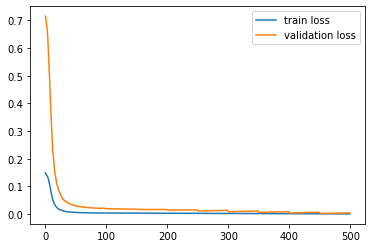

In [31]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

## Eval

In [32]:
test_dataset = MoaDataset(X_test, None, mode='eval')
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
preds = predict(model, device, test_loader)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [33]:
targets = [col for col in train_targets.columns]
sample_submission[targets] = preds
sample_submission.loc[test_features['cp_type']=='ctl_vehicle', targets] = 0
sample_submission.to_csv('submission.csv', index=False)